In [1]:
import abc
import os
import random

import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(os.urandom(16))

In [2]:
class RandomVariable(abc.ABC):
    @abc.abstractmethod
    def generate(self) -> int | float:
        pass

    @abc.abstractmethod
    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        pass

    def __call__(self, *args, **kwargs):
        return self.generate()


class DiscreteRandomVariable(RandomVariable, abc.ABC):
    @abc.abstractmethod
    def generate(self) -> int:
        pass

    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        raw = np.array([self.generate() for _ in range(n)])
        values, counts = np.unique(raw, return_counts=True)
        return values, counts


class ContinuousRandomVariable(RandomVariable, abc.ABC):
    @abc.abstractmethod
    def generate(self) -> float:
        pass

    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        raw = np.array([self.generate() for _ in range(n)])

        return np.histogram(raw, bins='sturges')

## Параметры

In [3]:
# Параметр лямбда для пуассоновской случайной переменной
LAMBDA_POISSON = 0.5
# Параметр лямбда для экспоненциальной случайной переменной
LAMBDA_EXP = 0.5
# Количество экспериментов
N = 1000
# Уровень значимости
ALPHA = 0.05

## Пуассоновская случайная переменная

In [4]:
class Poisson(DiscreteRandomVariable):
    def __init__(self, lambda_: float):
        self._lambda = lambda_

    @property
    def lambda_(self) -> float:
        return self._lambda

    @lambda_.setter
    def lambda_(self, value: float):
        self._lambda = value

    def generate(self) -> int:
        u = np.random.uniform(0, 1)
        i = 0
        f = p = np.exp(-self._lambda)
        while u >= f:
            p = self._lambda * p / (i + 1)
            f += p
            i += 1
        return i


In [89]:
@np.vectorize
def poisson_prob(lambda_: float, i: int) -> float:
    return np.exp(-lambda_) * (lambda_ ** i / np.math.factorial(i))

def chi2_poisson(values: np.ndarray, counts: np.ndarray) -> tuple[float, int]:
    n = int(np.sum(counts))
    if n > 5:
        while counts[-1] < 5 and len(counts) > 2:
            counts[-2] += counts[-1]
            counts = counts[:-1]
            values = values[:-1]
    lambda_s = np.sum(values * counts) / n
    p = poisson_prob(lambda_s, values)
    ni = p * n
    delta_n = counts - ni
    K = delta_n ** 2 / ni
    k = len(values) - 2
    return float(np.sum(K)), k

chi2 = 6.613347972076096
k = 2
chi2_crit = 5.991464547107983
Гипотезу отвергаем


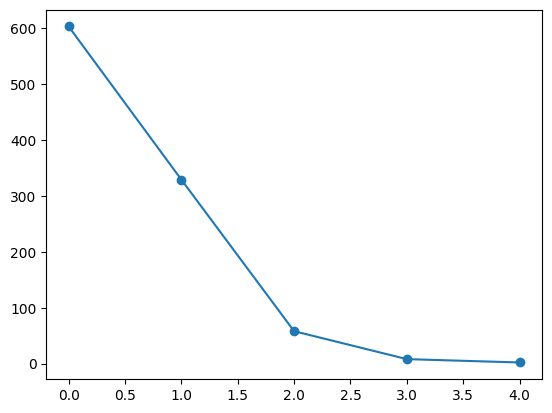

In [128]:
poisson = Poisson(LAMBDA_POISSON)
vals, c = poisson.generate_n(N)
plt.scatter(vals, c)
plt.plot(vals, c)

chi2, k = chi2_poisson(vals, c)
chi2_crit = scipy.stats.chi2.isf(ALPHA, df=k)
print(f"chi2 = {chi2}")
print(f"k = {k}")
print(f"chi2_crit = {chi2_crit}")
print(f"Гипотезу {'принимаем' if chi2 < chi2_crit else 'отвергаем'}")

## Экспоненциальная случайная переменная

In [7]:
class Exponential(ContinuousRandomVariable):
    def __init__(self, lambda_: float):
        self._lambda = lambda_

    @property
    def lambda_(self) -> float:
        return self._lambda

    @lambda_.setter
    def lambda_(self, value: float):
        self._lambda = value

    def generate(self) -> float:
        u = np.random.uniform(0, 1)
        return -1 / self._lambda * np.log(1 - u)


exponential = Exponential(LAMBDA_EXP)

In [134]:
@np.vectorize
def exp_prob(lambda_: float, start: float, end: float) -> float:
    return np.exp(-lambda_ * start) - np.exp(-lambda_ * end)

def chi2_exp(bins: np.ndarray, counts: np.ndarray) -> tuple[float, int]:
    n = int(np.sum(counts))
    if n > 5:
        while counts[-1] < 5 and len(counts) > 2:
            counts[-2] += counts[-1]
            counts = counts[:-1]
            bins = bins[:-1]
    values = (bins[1:] + bins[:-1]) / 2
    x_b = np.sum(values * counts) / n
    lambda_s = 1 / x_b
    p = exp_prob(lambda_s, bins[:-1], bins[1:])
    ni = p * n
    delta_n = counts - ni
    K = delta_n ** 2 / ni
    k = len(values) - 2
    return float(np.sum(K)), k

chi2 = 8.011655491295965
k = 8
chi2_crit = 15.507313055865454
Гипотезу принимаем


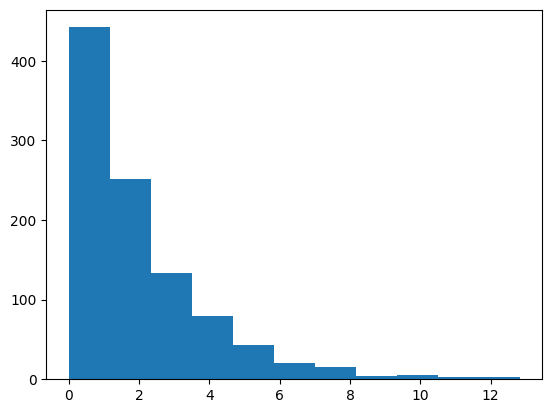

In [174]:
c, bins = exponential.generate_n(N)
plt.stairs(c, bins, fill=True)

chi2, k = chi2_exp(bins, c)
chi2_crit = scipy.stats.chi2.isf(ALPHA, df=k, loc=0, scale=1)
print(f"chi2 = {chi2}")
print(f"k = {k}")
print(f"chi2_crit = {chi2_crit}")
print(f"Гипотезу {'принимаем' if chi2 < chi2_crit else 'отвергаем'}")